In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from utilities import getFraudData, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

In [3]:
# Name of data file
datafile = "./data/creditcard.csv"

# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional of (y=1) cases held out for testing
testSize = 0.5

# Integer number of non-fraud cases kept in the training set
nonFraudInTraining = 5000

# Number of folds for GridSearchCV
nfolds = 5

# Number of samples (fraudulent, not fraudulent)
nSamples = (492, 125000)

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

names = ["Not Fraud", "Fraud"]

# # Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(31, 316, 4).round(), np.array([500, 1000, 2000, 3000])]).astype('int')
# learningCurveFolds = np.array([500, 1000, 2000, 3000]).astype('int')

# Fraction of data held out from the training dataset for cross validation during learning curve evaluation
lcTestSize = 0.2

In [4]:
# Used for plot names
est = "fraud_knn"
scoreText = "F1-Score"

In [5]:
data = getFraudData(datafile, nSamples, randomSeed)
print(f"Got data of shape: {data.shape}")

featColNames = [name for name in data.columns if ((name != "Class") and (name != "Time"))] 

print(f"Got feature columns {featColNames}")

Importing data with 492 fraudulent and 125000 not fraudulent cases
Got data of shape: (125492, 31)
Got feature columns ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [6]:
# Create X, y, XTest, yTest
# Because of the imbalance in data, use half of the fraud cases and only 5000 of the non-fraud cases for training.  Then Test on the rest

fraudXFull = data.loc[data.Class == 1, featColNames].values
fraudyFull = data.loc[data.Class == 1, 'Class'].values

fraudX, fraudXTest, fraudy, fraudyTest = train_test_split(fraudXFull, fraudyFull, 
                                                      test_size=testSize, random_state=randomSeed)

notFraudXFull = data.loc[data.Class == 0, featColNames].values
notFraudyFull = data.loc[data.Class == 0, 'Class'].values

# Using train_test_split "backwards" because I want 5000 examples in my training set and the rest in test
notFraudXTest, notFraudX, notFraudyTest, notFraudy = train_test_split(notFraudXFull, notFraudyFull, 
                                                      test_size=nonFraudInTraining, random_state=randomSeed)

print('')
print(f'fraudX.shape = {fraudX.shape}')
print(f'fraudy.shape = {fraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(fraudy == 1).sum() / float(len(fraudy))} (should be 1)')

print('')
print(f'notFraudX.shape = {notFraudX.shape}')
print(f'notFraudy.shape = {notFraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(notFraudy == 1).sum() / float(len(notFraudy))} (should be 1)')

XUnscaled = np.concatenate([fraudX, notFraudX])
XTestUnscaled = np.concatenate([fraudXTest, notFraudXTest])

# Scale X, XTest for use in learning algorithm 
scaler = StandardScaler()
X = scaler.fit_transform(XUnscaled)
XTest = scaler.transform(XTestUnscaled)

y = np.concatenate([fraudy, notFraudy])
yTest = np.concatenate([fraudyTest, notFraudyTest])

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(y == 1).sum() / float(len(y))} (should be ~0.05)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be ~.001)')



fraudX.shape = (246, 29)
fraudy.shape = (246,)
Ratio of y=1 to y=0 for Training data: 1.0 (should be 1)

notFraudX.shape = (5000, 29)
notFraudy.shape = (5000,)
Ratio of y=1 to y=0 for Training data: 0.0 (should be 1)

X.shape = (5246, 29)
y.shape = (5246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.04689287075867327 (should be ~0.05)

XTest.shape = (120246, 29)
yTest.shape = (120246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.0020458060975001246 (should be ~.001)


# Initial Parameter Grid Search

In [7]:
paramGrid = {
    'n_neighbors': [1, 2, 3, 5, 7, 10, 20, 30],
    'weights': ['distance', 'uniform'],
}

nData = -1 # (all)
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(KNeighborsClassifier(), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True, scoring='f1')

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 5245 data samples
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   53.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   57.0s finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014353,0.002421,0.328738,0.069856,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.857143,0.888889,0.900000,...,0.884203,0.016362,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.017354,0.003251,0.580836,0.236435,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.857143,0.888889,0.900000,...,0.884203,0.016362,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.023535,0.005699,0.859903,0.034348,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.857143,0.888889,0.900000,...,0.884203,0.016362,13,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.031715,0.004433,0.933005,0.048980,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.872340,0.873563,0.923077,...,0.895682,0.022901,8,0.943396,0.926431,0.932249,0.926431,0.946524,0.935006,0.008459
4,0.026129,0.003536,0.885385,0.030054,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.863158,0.903226,0.936170,...,0.912357,0.029057,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.031119,0.002032,1.032997,0.055431,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.863158,0.913043,0.924731,...,0.909742,0.024681,6,0.949062,0.929730,0.932976,0.932976,0.944591,0.937867,0.007544
6,0.034908,0.003624,1.110296,0.082467,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.891304,0.911111,0.936170,...,0.914743,0.023160,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.031817,0.002149,1.000332,0.037481,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.879121,0.923077,0.924731,...,0.910118,0.021917,4,0.920548,0.912568,0.921409,0.915531,0.924324,0.918876,0.004240
8,0.027725,0.001164,1.031105,0.058992,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.866667,0.923077,0.924731,...,0.912355,0.026952,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,0.028522,0.002410,0.970561,0.024922,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.866667,0.923077,0.901099,...,0.902899,0.024237,7,0.912088,0.912568,0.906593,0.907104,0.912568,0.910184,0.002734


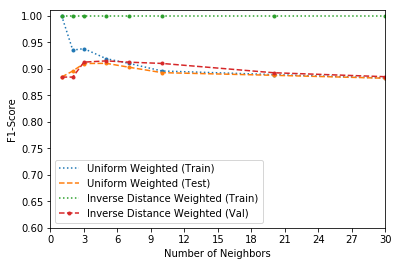

In [10]:
gs_results_df = pd.DataFrame(gs.cv_results_)

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_weights == 'uniform'].plot(x='param_n_neighbors', y='mean_train_score', label='Uniform Weighted (Train)', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_weights == 'uniform'].plot(x='param_n_neighbors', y='mean_test_score', label='Uniform Weighted (Test)', ax=ax, marker='.', ls="--")
gs_results_df.loc[gs_results_df.param_weights == 'distance'].plot(x='param_n_neighbors', y='mean_train_score', label='Inverse Distance Weighted (Train)', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_weights == 'distance'].plot(x='param_n_neighbors', y='mean_test_score', label='Inverse Distance Weighted (Val)', ax=ax, marker='.', ls="--")
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Number of Neighbors")
ax.set_ylabel(scoreText)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Force integer x axis
ax.set_xlim(left=0, right=gs_results_df.param_n_neighbors.max())
ax.set_ylim(bottom=accuracyMin, top=1.01)

fig.savefig(est + pltNameSuffix + "_gs")

In [11]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
yPred =  gs.best_estimator_.predict(X)
print(f'On the training data, we see precision and recall of:')
cr = classification_report(y, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)
print(f'but for the held-out test data we obtain just:')
yPred =  gs.best_estimator_.predict(XTest)
cr = classification_report(yTest, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)

From this, we choose the following parameters for computing the learning curve:
{'n_neighbors': 5, 'weights': 'distance'}
On the training data, we see precision and recall of:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00      5000
      Fraud       1.00      1.00      1.00       246

avg / total       1.00      1.00      1.00      5246

but for the held-out test data we obtain just:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00    120000
      Fraud       0.57      0.76      0.65       246

avg / total       1.00      1.00      1.00    120246



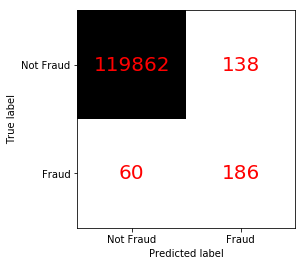

In [12]:
ax = plotConfusionMatrix(yTest, yPred, names, savefig=est + pltNameSuffix + "_confusion")

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

In [13]:
lc_params = copy.deepcopy(gs.best_params_)
lc_params['weights'] = 'uniform'

lcNameBase = est + "_" + str(lc_params['weights'] ) + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(KNeighborsClassifier(**lc_params), X, y, 
                          testSize = lcTestSize, scorer=f1_score, 
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                          randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'n_neighbors': 5, 'weights': 'uniform'}
Over 8 folds: [  31   67  146  316  500 1000 2000 3000]
Indices included at fold 0: 31
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.01s
Indices included at fold 1: 67
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.01s
Indices included at fold 2: 146
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.02s
Indices included at fold 3: 316
	Model trained in 0.00s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.02s
	Total time for this iteration = 0.04s
Indices included at fold 4: 500
	Model trained in 0.00s
	Model Scored on Training Data in 0.02s
	Model Scored on Test Data in 0.04s
	Total time for this iteration = 0.07s
Indices in

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	Model Scored on Training Data in 0.09s
	Model Scored on Test Data in 0.09s
	Total time for this iteration = 0.19s
Indices included at fold 6: 2000
	Model trained in 0.00s
	Model Scored on Training Data in 0.35s
	Model Scored on Test Data in 0.20s
	Total time for this iteration = 0.57s
Indices included at fold 7: 3000
	Model trained in 0.01s
	Model Scored on Training Data in 0.68s
	Model Scored on Test Data in 0.25s
	Total time for this iteration = 0.94s


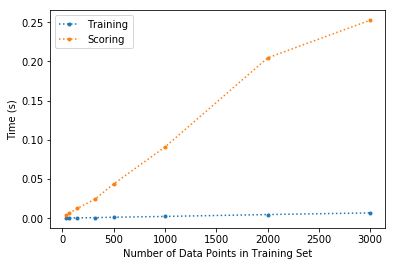

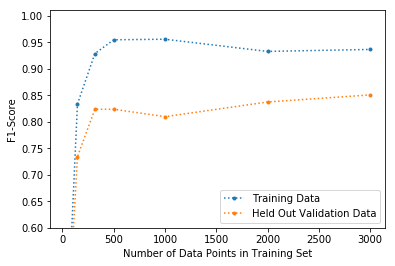

In [14]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=1.01, ylabel = scoreText, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [15]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.851 achieved with 3000 samples
